# Instrução do Projeto

A Film Junky Union, uma nova comunidade para entusiastas de filmes clássicos, está desenvolvendo um sistema para filtrar e categorizar resenhas de filmes. O objetivo é treinar um modelo para detectar automaticamente resenhas negativas. Eu irei utilizar um conjunto de dados de resenhas de filmes do IMDB com rotulagem de polaridade para criar um modelo para classificar resenhas como positivas e negativas. O objetivo é atingir o valor de 0,85 com a métrica f1.

## Inicialização

In [1]:
import math
import re
import numpy as np
import pandas as pd
import spacy

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates



from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# a próxima linha fornece gráficos de melhor qualidade em telas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# isso é para usar progress_apply, leia mais em https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Carregar Dados

In [73]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head(3)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
df_reviews[['review','sp','pos','ds_part']].head()

,review,sp,pos,ds_part
0,The pakage implies that Warren Beatty and Gold...,neg,0,train
1,How the hell did they get this made?! Presenti...,neg,0,train
2,There is no real story the film seems more lik...,neg,0,test
3,Um .... a serious film about troubled teens in...,pos,1,test
4,I'm totally agree with GarryJohal from Singapo...,pos,1,test


In [8]:
df_reviews['ds_part'].value_counts()

train    23796
test     23535
Name: ds_part, dtype: int64

In [9]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

In [74]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

### Conclusão

Os dados tem 47331 linhas e 17 colunas. Os tipos estão certos, existem valores ausentes, mas as colunas importantes possuem os seus valores.

## AED

Vamos verificar o número de filmes e resenhas ao longo dos anos.

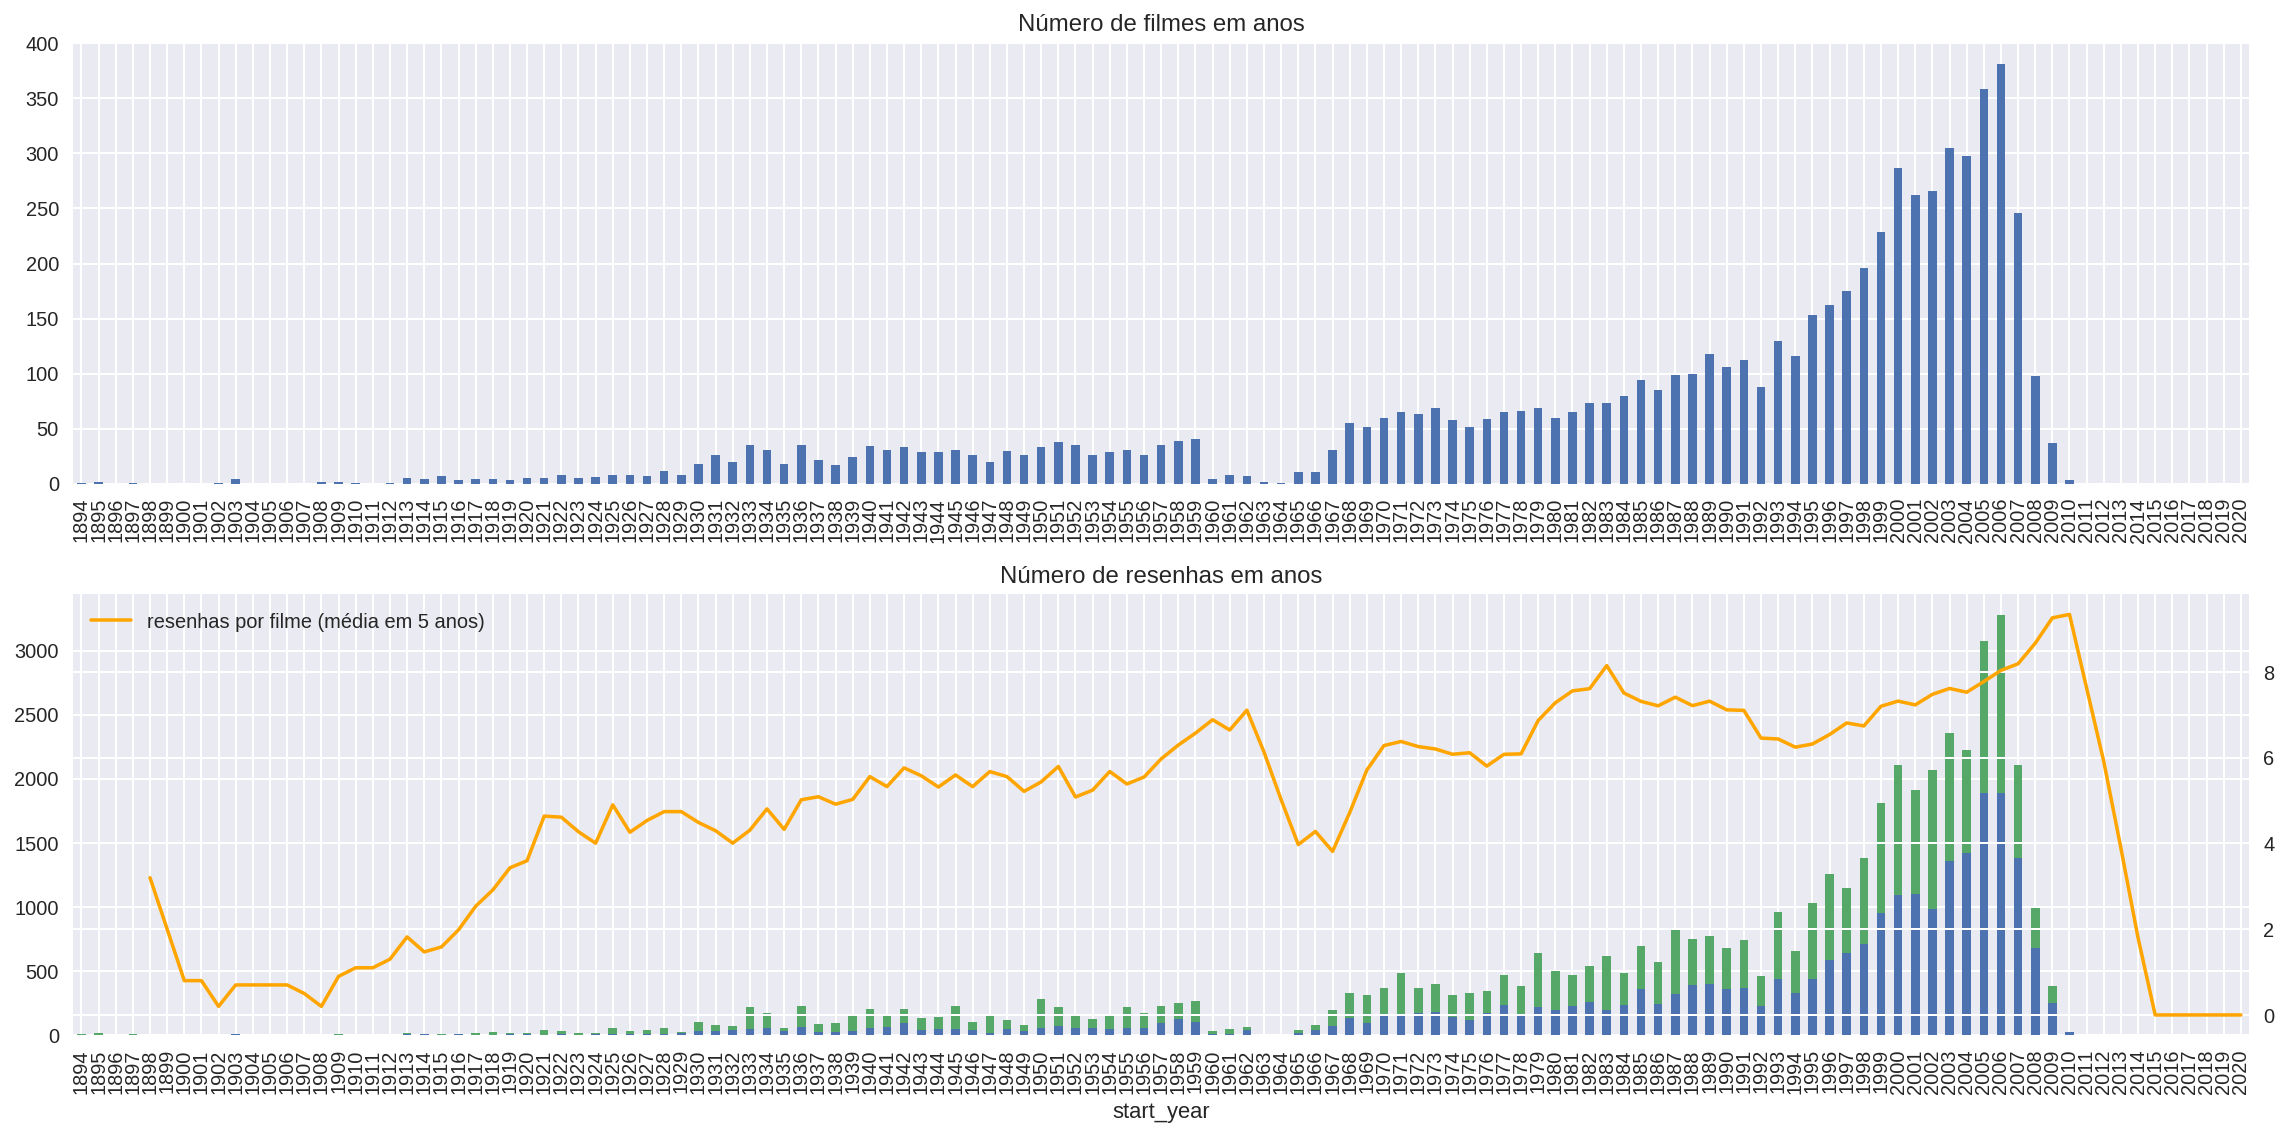

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de filmes em anos')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='resenhas por filme (média em 5 anos)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de resenhas em anos')

fig.tight_layout()

Historicamente, ao longo dos anos, o número de filmes aumenta até 2007. Consequentemente, as críticas por filme aumentaram para 3.250 críticas.

Vamos verificar a distribuição do número de resenhas por filme com a contagem exata e o KDE (só para saber como isso pode diferir da contagem exata).

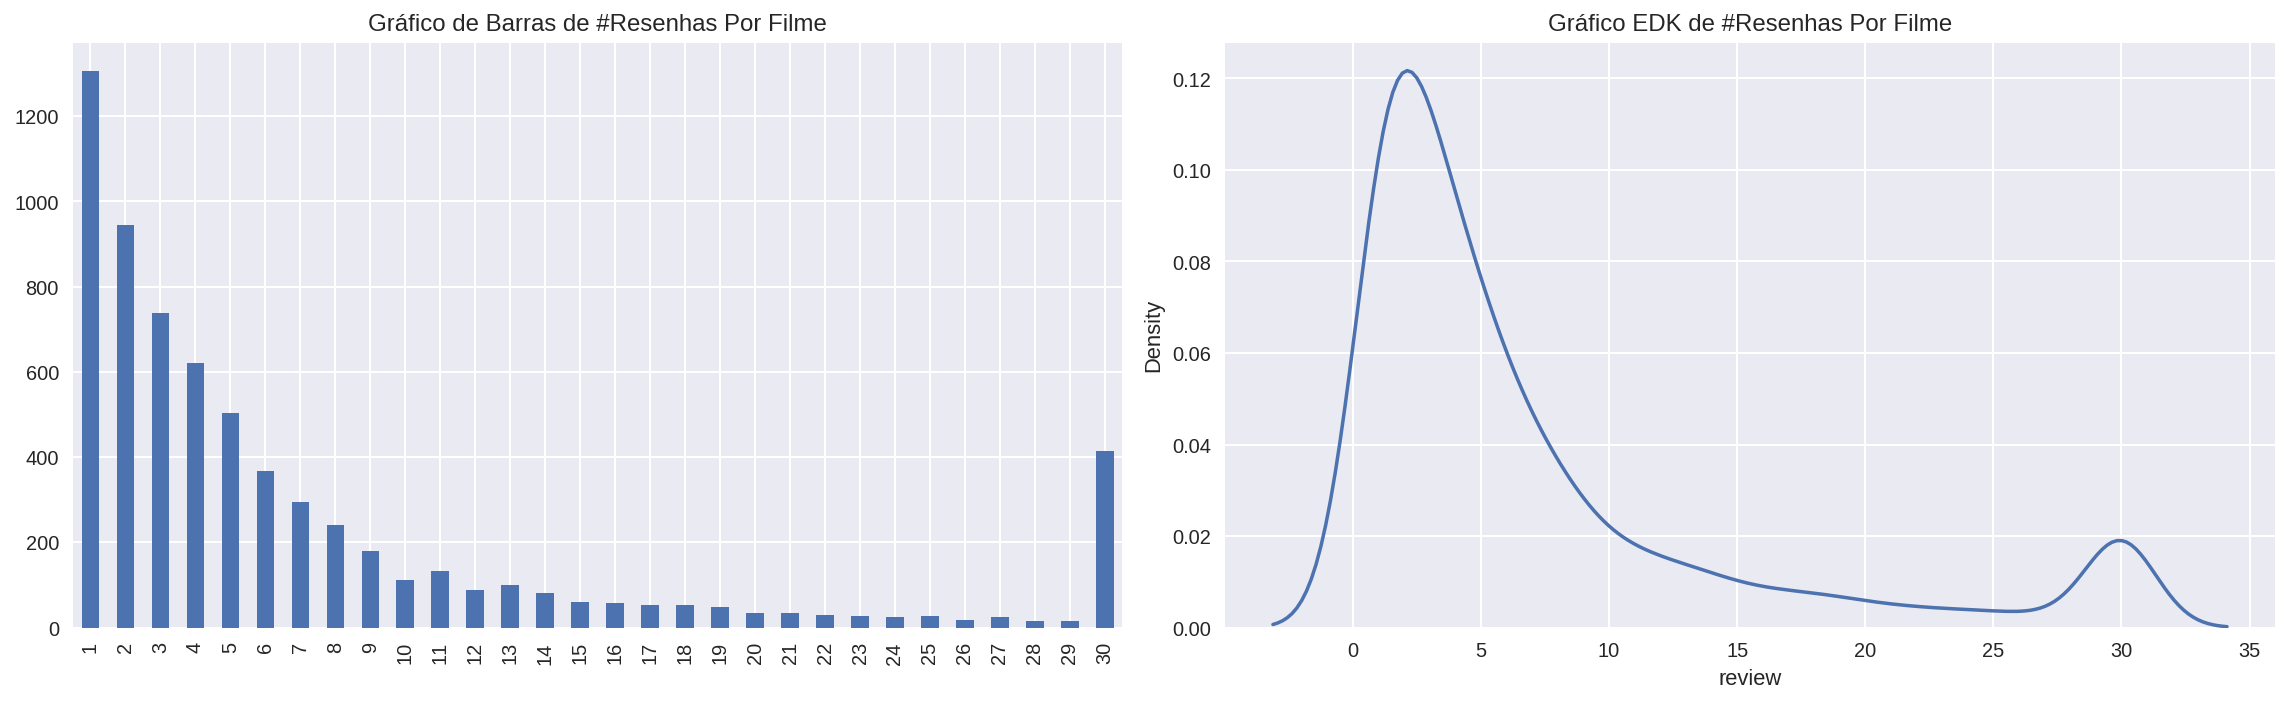

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de Barras de #Resenhas Por Filme')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico EDK de #Resenhas Por Filme')

fig.tight_layout()

A grande maioria dos filmes tiveram até 5 resenhas.

In [81]:
df_reviews['pos'].value_counts(normalize=True)

0    0.501046
1    0.498954
Name: pos, dtype: float64

As classes estão equilibradas, isso significa que não será necessário equilibrá-las.

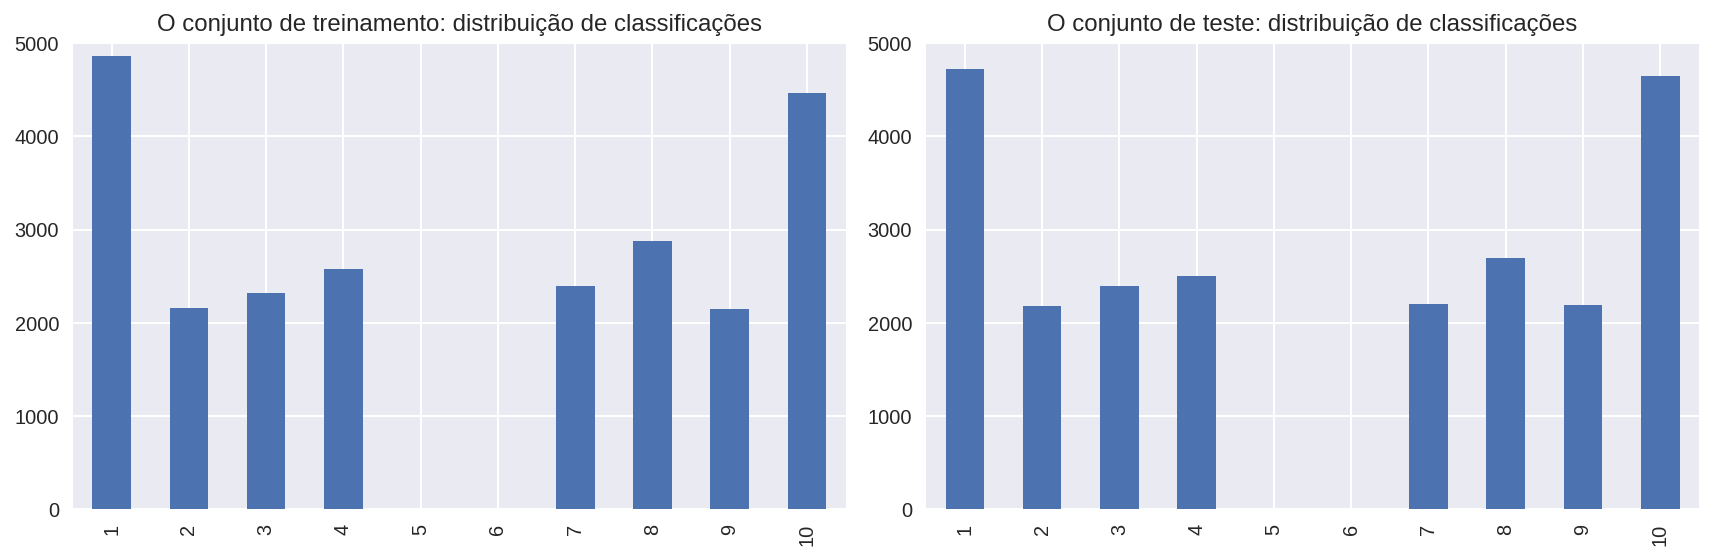

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de treinamento: distribuição de classificações')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de teste: distribuição de classificações')

fig.tight_layout()

A distribuição das classificações do conjuntos de treino e teste se mantiveram equilibrada.

Distribuição de resenhas negativas e positivas ao longo dos anos para duas partes do conjunto de dados

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


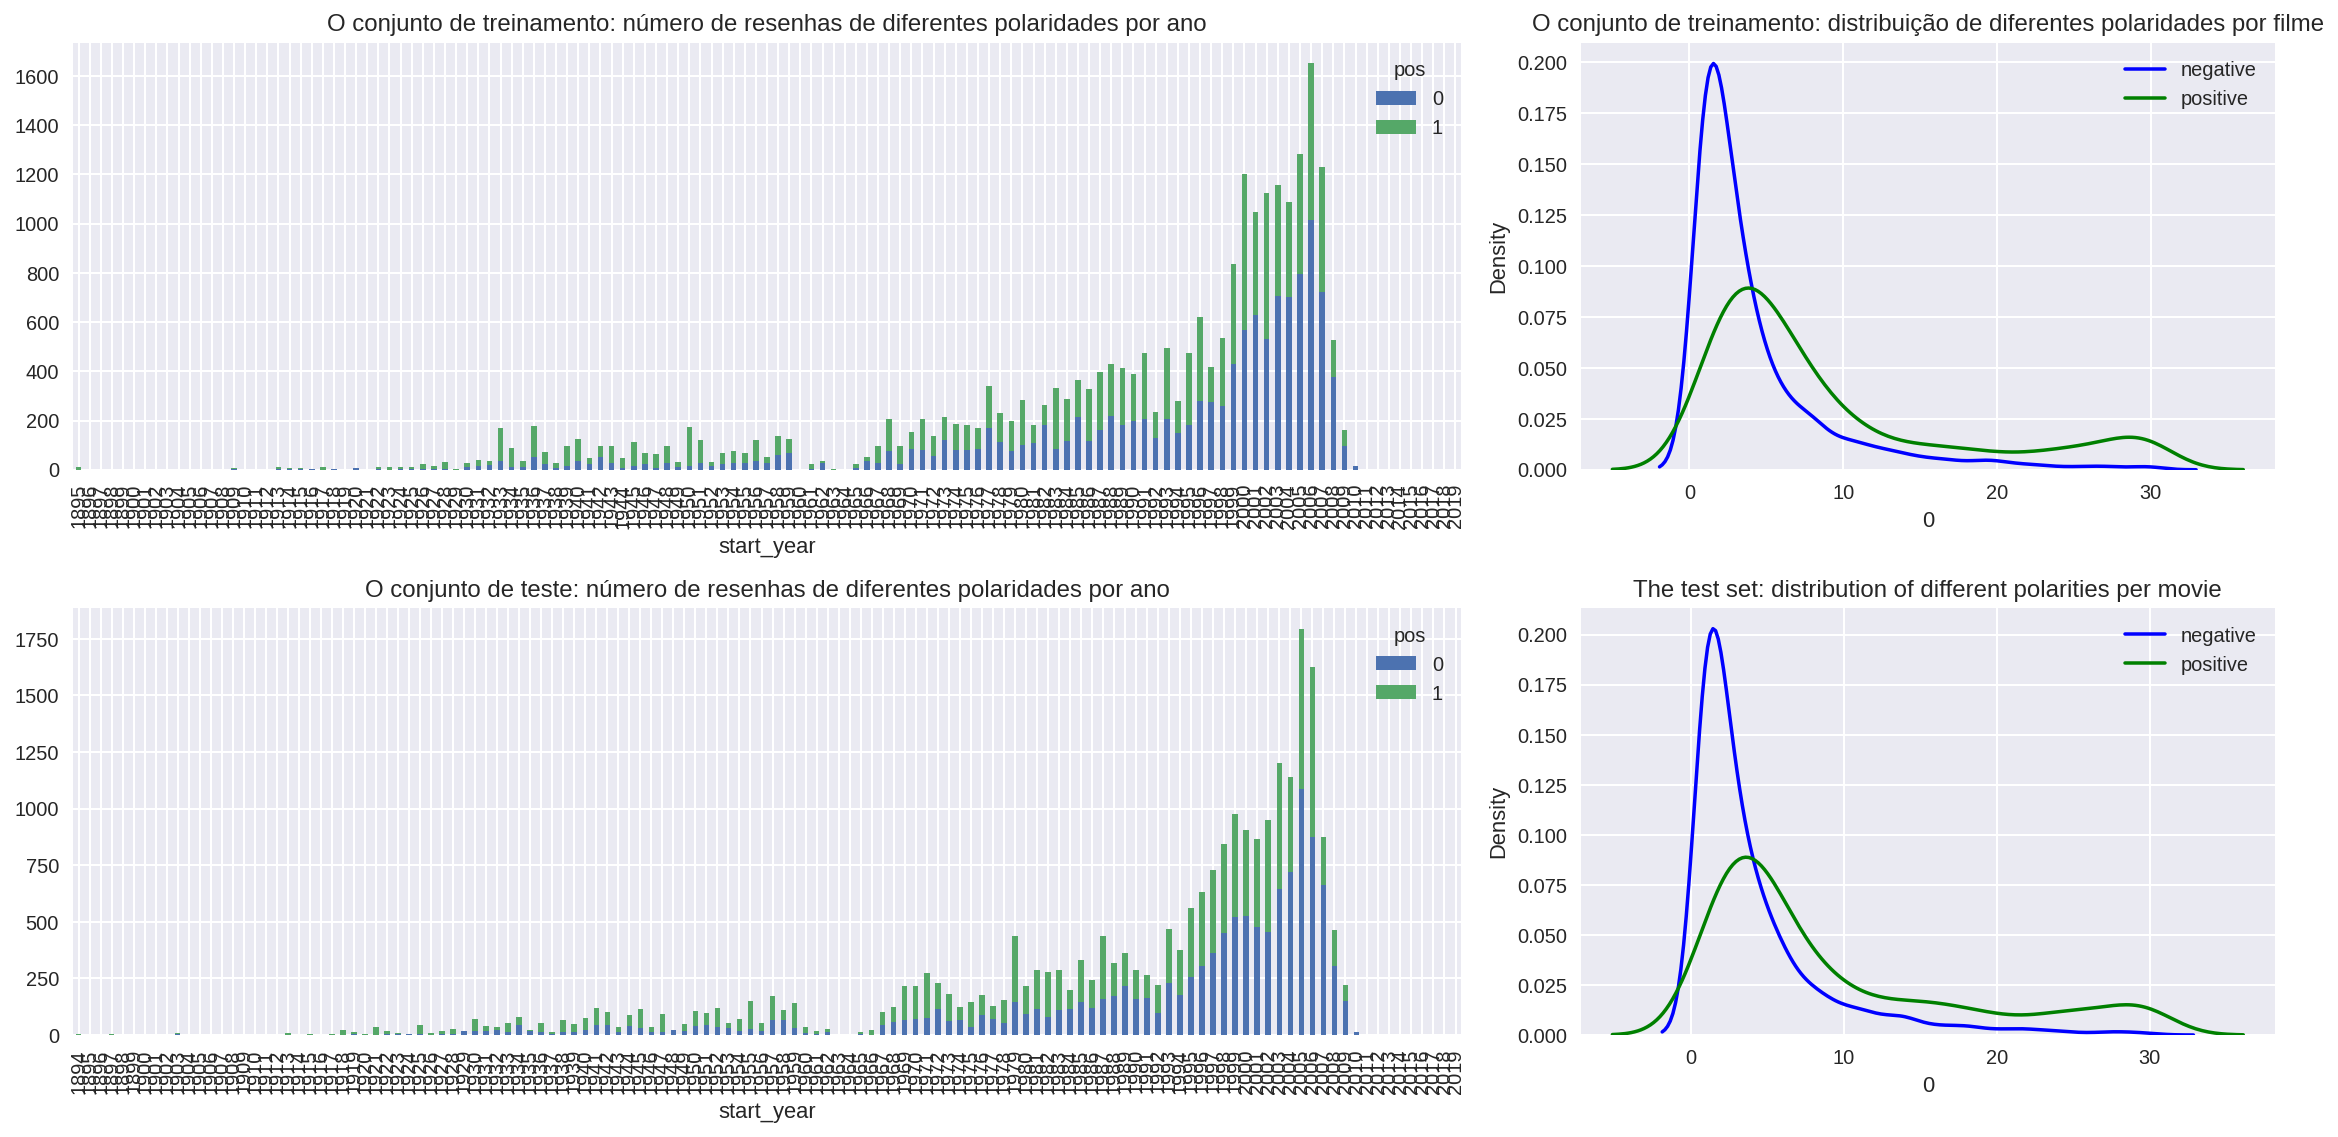

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de treinamento: número de resenhas de diferentes polaridades por ano')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('O conjunto de treinamento: distribuição de diferentes polaridades por filme')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de teste: número de resenhas de diferentes polaridades por ano')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

A distribuição de classes estão bem parecidas para os dois conjuntos.

## Procedimento de Avaliação

Compondo uma rotina de avaliação que pode ser utilizada para todos os modelos deste projeto

In [15]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threbshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalização

Assumimos que todos os modelos abaixo aceitam textos em letras minúsculas e sem dígitos, sinais de pontuação, etc.

In [16]:
def clear_text(data):

    clean_data = re.sub(r"[^a-zA-Z']", " ", data)
    clean_data = " ".join(clean_data.split())
    return clean_data.lower()

In [17]:
df_reviews['review_norm'] = df_reviews['review'].apply(clear_text)

In [18]:
df_reviews['review_norm'].head(5)

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i'm totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

## Preparando os dados para o treinamento.

Felizmente, todo o conjunto de dados já está dividido em partes de treinamento/teste. A opção correspondente é 'ds_part'.

### Divisão dos dados.

In [20]:
# Divisão do conjunto de teste e treino.
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

# característica 
y_train = df_reviews_train['pos']
y_test = df_reviews_test['pos']

# objetios
x_train = df_reviews_train['review_norm']
x_test = df_reviews_test['review_norm']

print('features_train',x_train.shape)
print('features_test',x_test.shape)
print('target_train',y_train.shape)
print('target_test',y_test.shape)

features_train (23796,)
features_test (23535,)
target_train (23796,)
target_test (23535,)


### Lematização e tokenização.

Os dados serão preparados com duas bibliotecas diferentes spacy e nltk. Vou comparar o desempenho dos modelos treinados com técnicas diferentes.

In [ ]:
# Natural Language Toolkit
def lemmatize_nltk(text):
    lemmatizer  = WordNetLemmatizer() 
    tokens = word_tokenize(text.lower()) 
    lemmas = [lemmatizer.lemmatize(token) for token in tokens] 
    lemmatized = " ".join(lemmas) 
    return lemmatized

#  Spacy 
def lemmatize_spacy(text):
    doc = nlp(text.lower())
    lemmas = []
    lemmas = [token.lemma_ for token in doc]
    lemmatize_spacy = " ".join(lemmas)
    return lemmatize_spacy

In [ ]:
stop_words = set(stopwords.words('english'))
# TF-IDF nltk.
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
# TF-IDF spacy.
count_tf_idf2 = TfidfVectorizer(stop_words=stop_words) 

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
# Lemmatização nlkt.
x_train_idf = x_train.apply(lemmatize_nltk)
x_test_idf = x_test.apply(lemmatize_nltk)
# TF-IDF nltk.
x_train_idf = count_tf_idf.fit_transform(x_train_idf)
x_test_idf = count_tf_idf.transform(x_test_idf)

In [ ]:
%%time
# Lemmatização spacy.
x_train_idf2 = x_train.apply(lemmatize_spacy)
x_test_idf2 = x_test.apply(lemmatize_spacy)
# TF-IDF spacy.
x_train_idf2 = count_tf_idf2.fit_transform(x_train_idf2)
x_test_idf2 = count_tf_idf2.transform(x_test_idf2)

## Trabalhando com modelos

### Modelo 0 - Constante

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


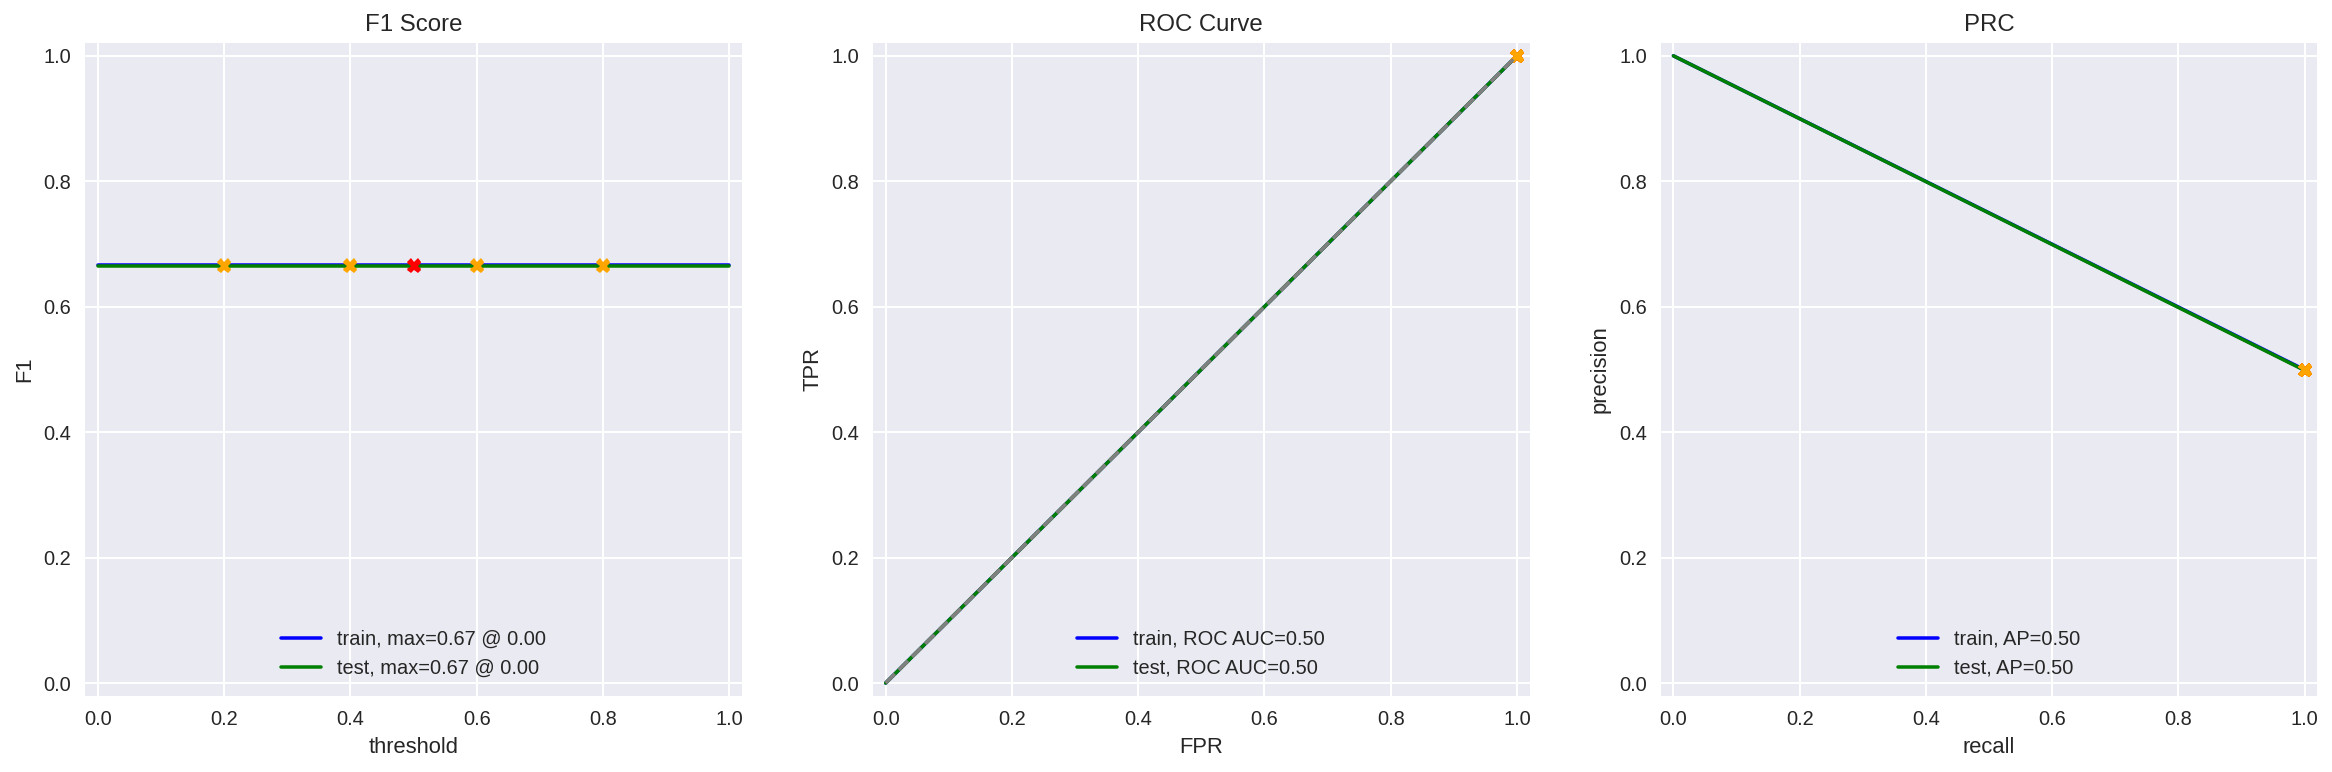

In [22]:
# Treinamento.
model_dummy = DummyClassifier(strategy='constant',constant=1)
model_dummy.fit(x_train,y_train)
# Avaliação do modelo.
evaluate_model(model_dummy, x_train, y_train, x_test, y_test)

### Modelo 1 - NLTK, TF-IDF e Regressão Linear.

TF-IDF

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


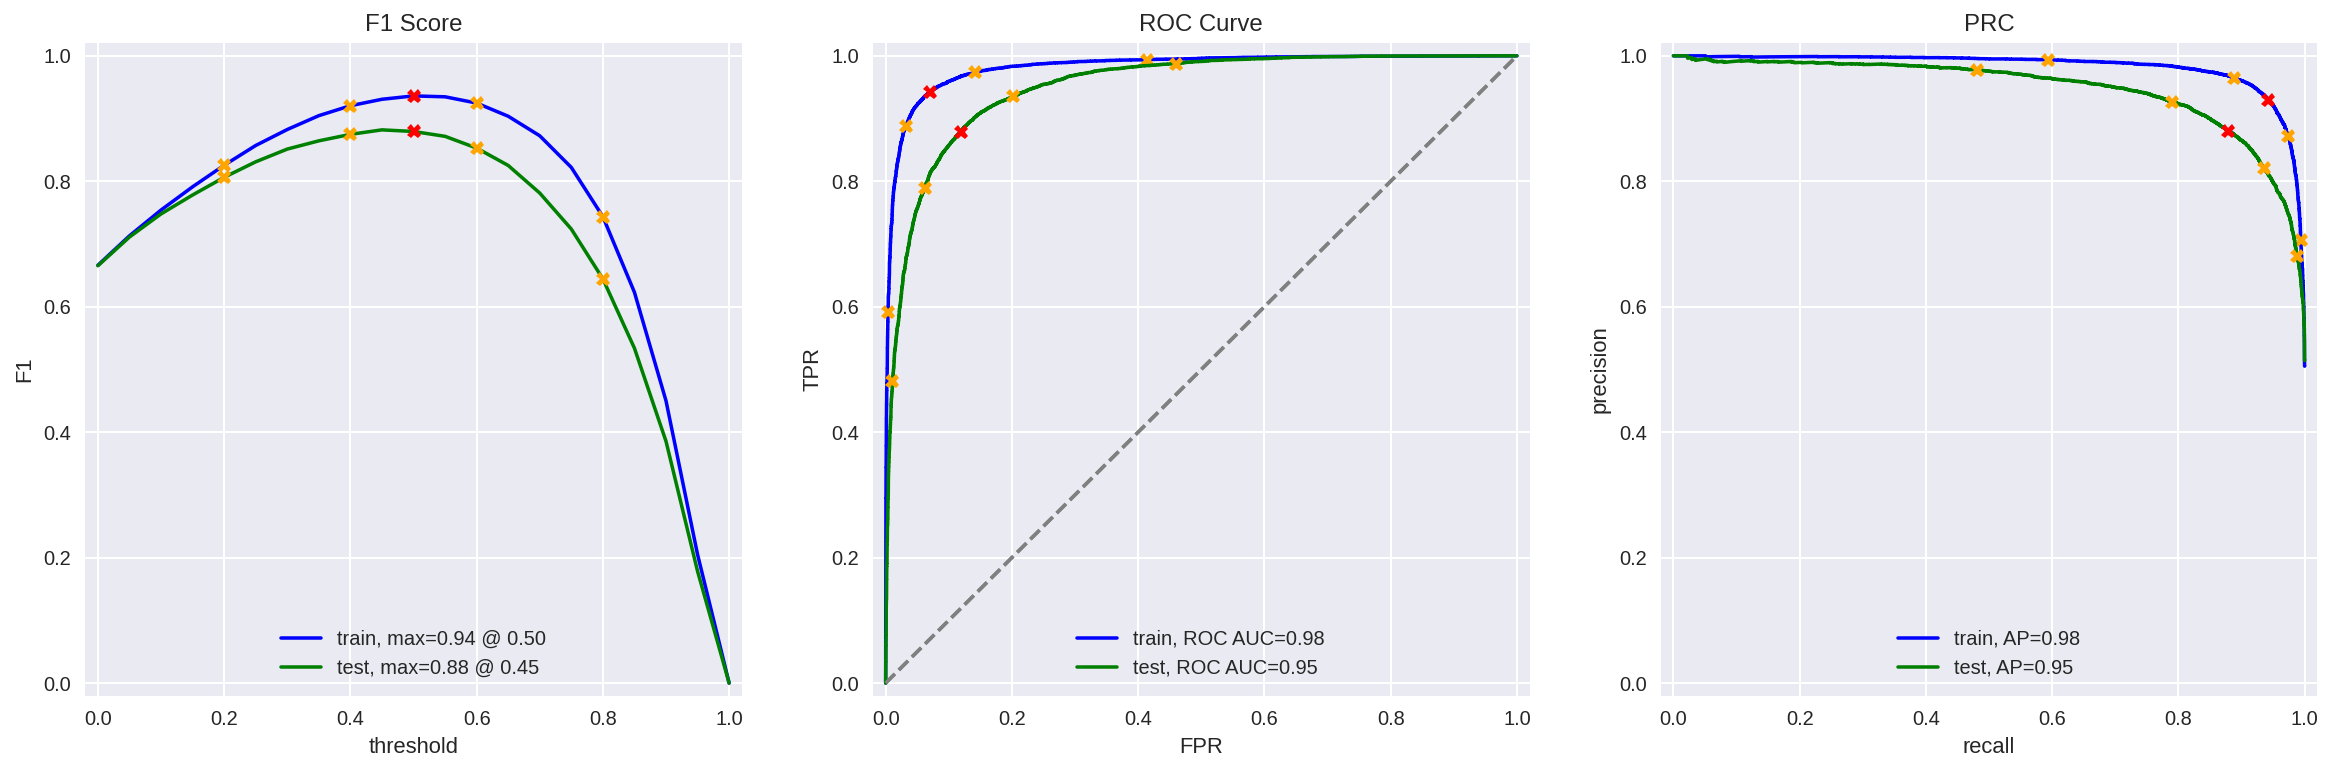

In [26]:
# Treinamento.
model1 = LogisticRegression(solver='liblinear',random_state=123)
model1.fit(x_train_idf,y_train)
# Avaliação.
evaluate_model(model1, x_train_idf, y_train, x_test_idf, y_test)

### Modelo 2 NLTK, TF-IDF e LGBMClassifier.

          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


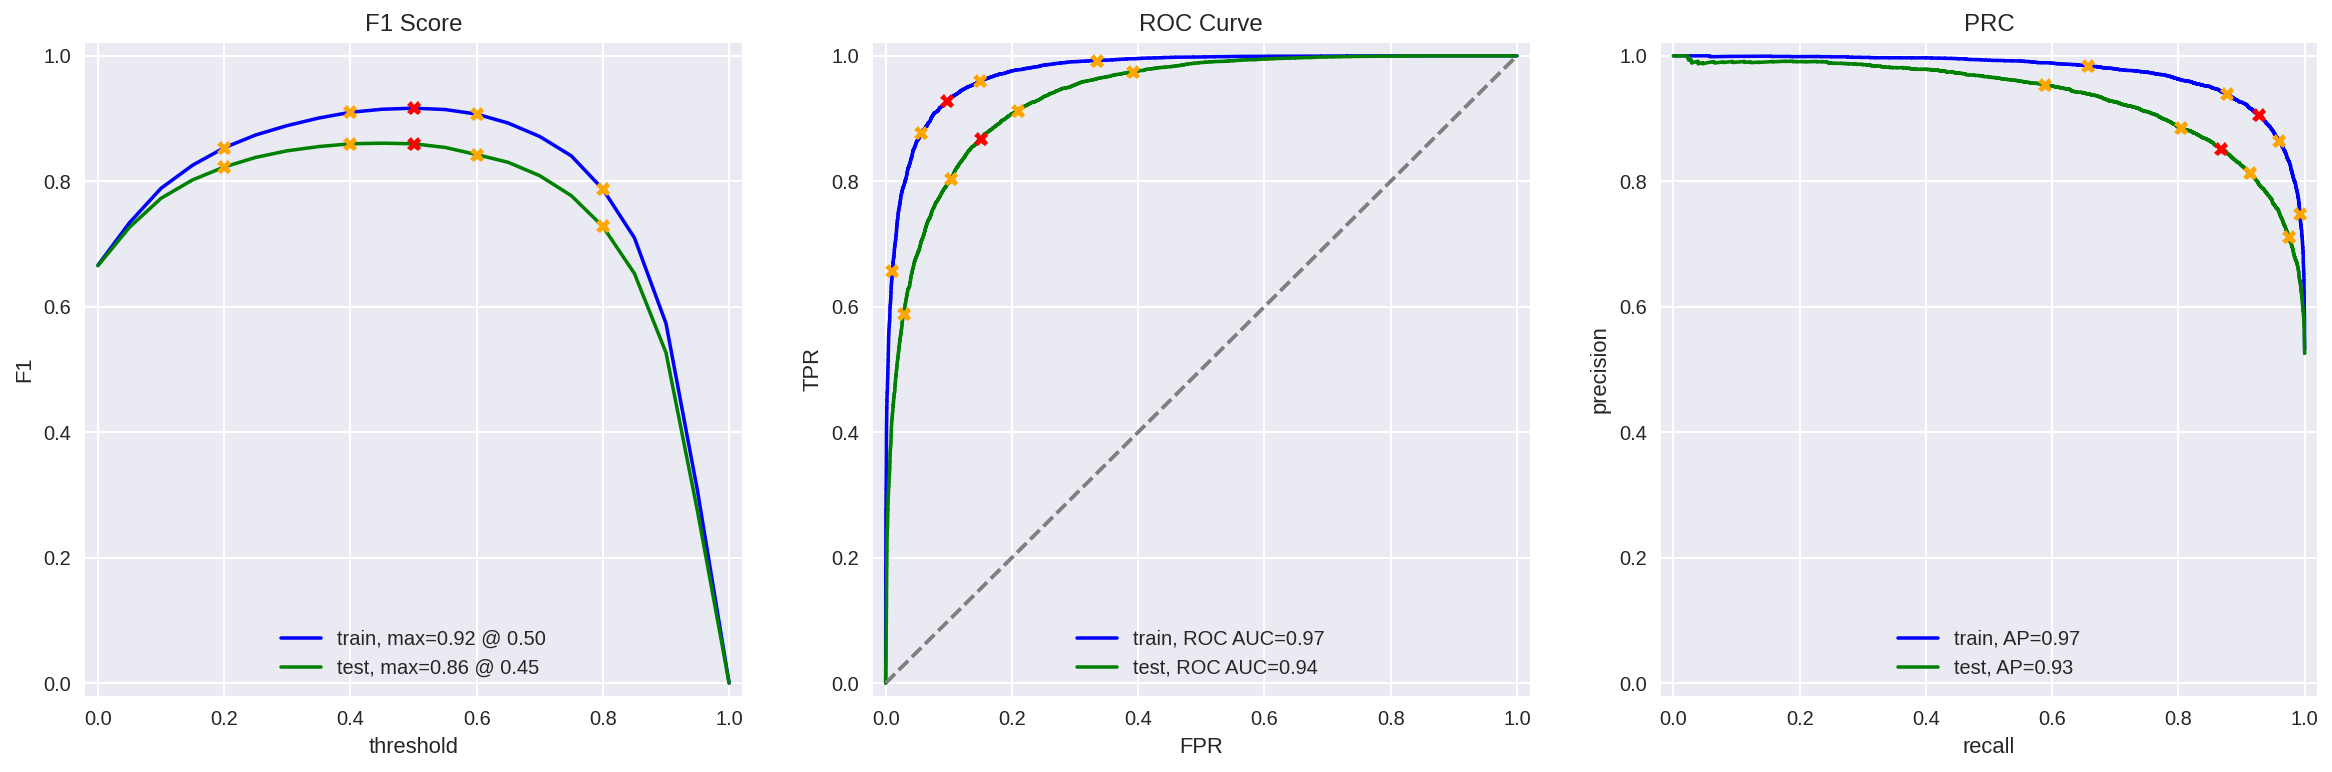

In [63]:
# Treinamento do modelo.
model2 = LGBMClassifier(random_state=12345,learning_rate=0.1)
model2.fit(x_train_idf,y_train)
# Avaliação.
evaluate_model(model2, x_train_idf, y_train, x_test_idf, y_test)

### Modelo 3 - spaCy, TF-IDF e Regressão Linear.

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


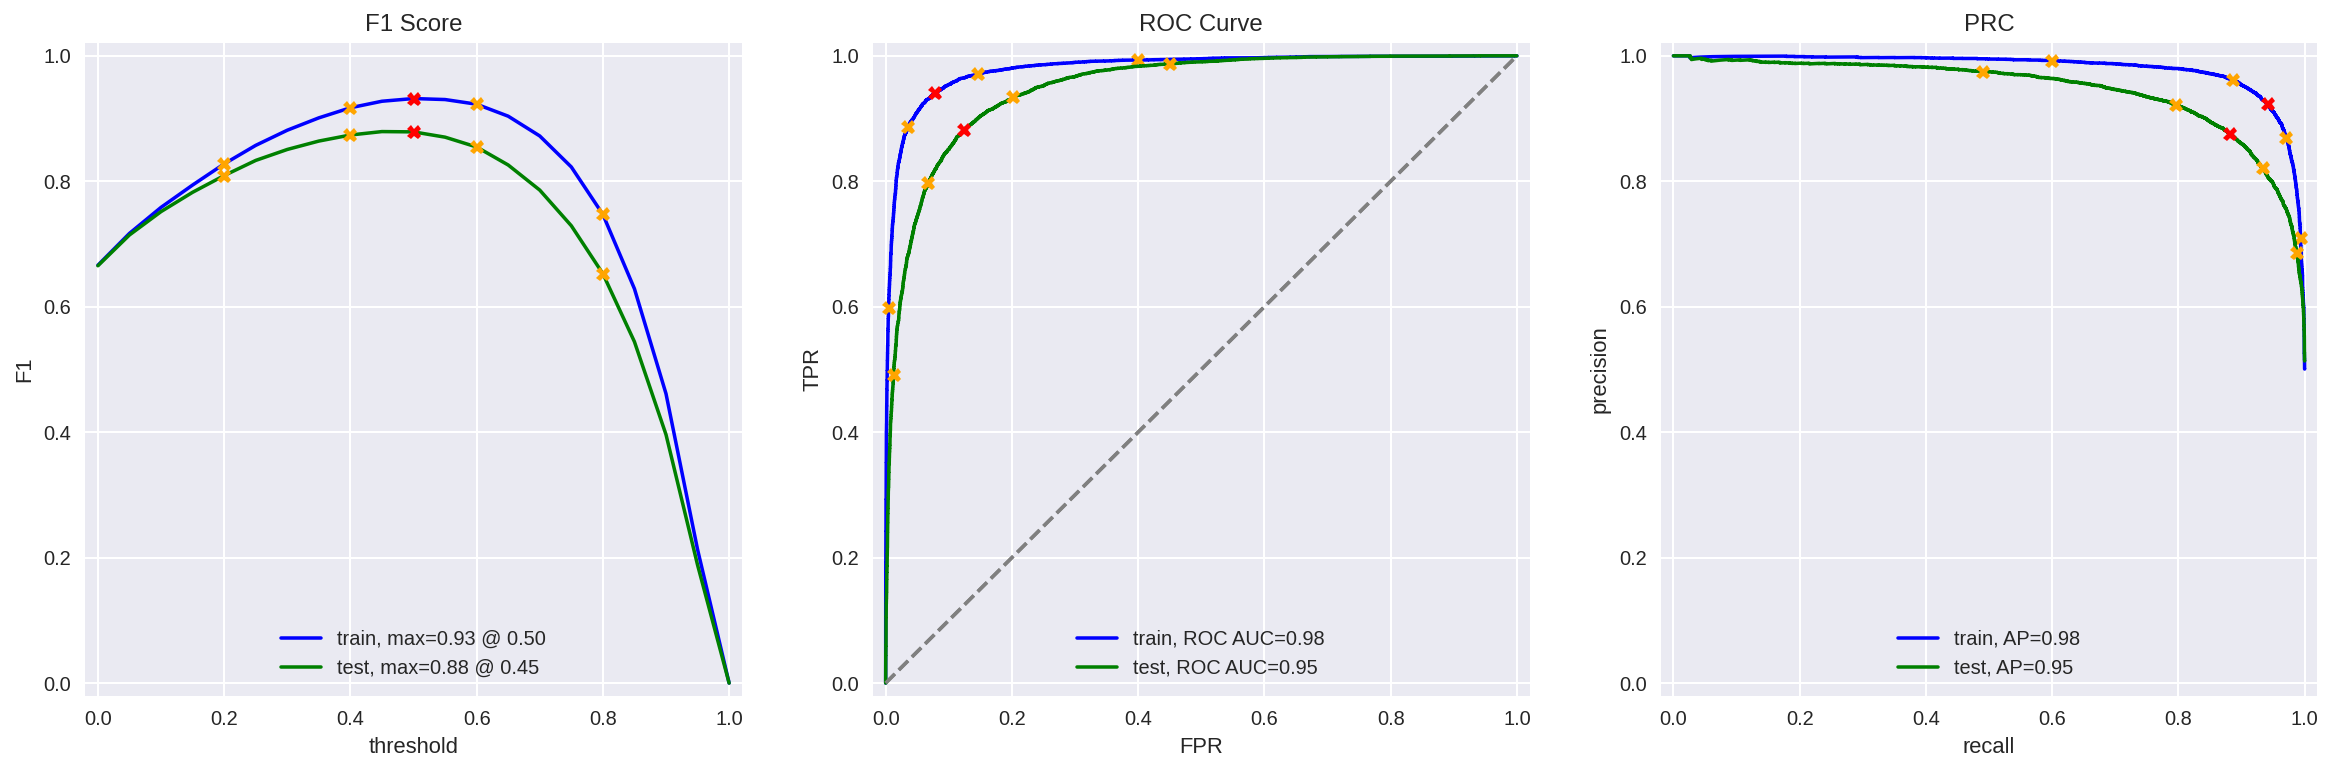

In [36]:
# Treinamento.
model3 = LogisticRegression(solver='liblinear',random_state=1234)
model3.fit(x_train_idf2,y_train)
# Avaliação.
evaluate_model(model3, x_train_idf2, y_train, x_test_idf2, y_test)

### Modelo 4 - SpaCy, TF-IDF e LGBMClassifier

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


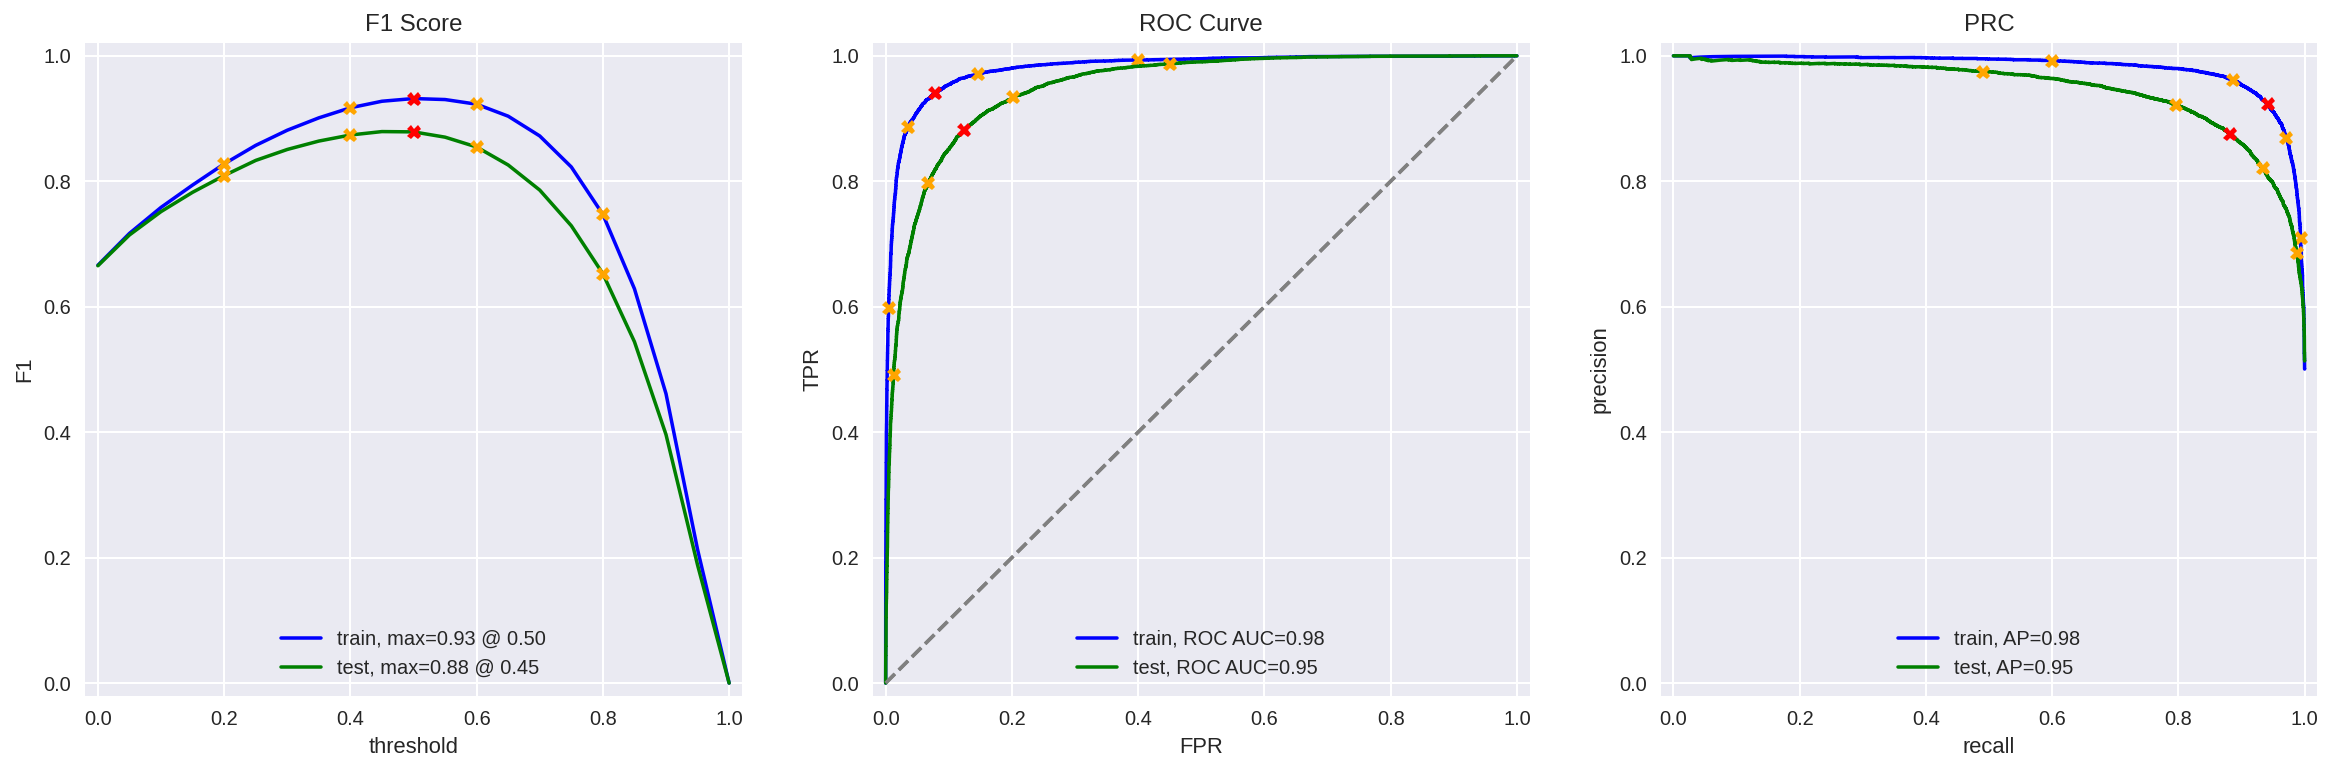

In [38]:
# Treinamento.
model4 = LGBMClassifier()
model4.fit(x_train_idf2,y_train)
# Avaliação
evaluate_model(model3, x_train_idf2, y_train, x_test_idf2, y_test)

## Minhas Resenhas

In [40]:
# sinta-se à vontade para remover completamente essas resenhas e experimentar seus modelos nas suas próprias resenhas, as abaixo são apenas exemplos

my_reviews = pd.DataFrame([
    'Eu simplesmente não gostei, não é meu tipo de filme.',
    'Bem, eu fiquei entediado e dormi no meio do filme.',
    'Eu fiquei realmente fascinado com o filme',    
    'Os atores pareciam muito velhos e desinteressados, e mesmo assim foram pagos para participar do filme. Que roubo de dinheiro sem vergonha.',
    'Eu não esperava que a nova versão fosse tão boa! Os escritores realmente se importaram com o material original',
    'O filme tem seus prós e contras, mas eu sinto que em geral é um filme decente. Eu posso me imaginar indo assistir novamente.',
    'Que tentativa podre de comédia. Nem uma única piada cai, todo mundo age de forma irritante e barulhenta, nem crianças não vão gostar disso!',
    'Lançar na Netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após episódio, deste emocionante e inteligente novo drama.'
], columns=['review'])


my_reviews['review_norm'] =  my_reviews['review'].apply(clear_text)

my_reviews

,review,review_norm
0,"Eu simplesmente não gostei, não é meu tipo de ...",eu simplesmente n o gostei n o meu tipo de filme
1,"Bem, eu fiquei entediado e dormi no meio do fi...",bem eu fiquei entediado e dormi no meio do filme
2,Eu fiquei realmente fascinado com o filme,eu fiquei realmente fascinado com o filme
3,Os atores pareciam muito velhos e desinteressa...,os atores pareciam muito velhos e desinteressa...
4,Eu não esperava que a nova versão fosse tão bo...,eu n o esperava que a nova vers o fosse t o bo...
5,"O filme tem seus prós e contras, mas eu sinto ...",o filme tem seus pr s e contras mas eu sinto q...
6,Que tentativa podre de comédia. Nem uma única ...,que tentativa podre de com dia nem uma nica pi...
7,Lançar na Netflix foi uma jogada corajosa e eu...,lan ar na netflix foi uma jogada corajosa e eu...


### Modelo 1 - Regressão Logística.

In [52]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model1.predict_proba(count_tf_idf.transform(texts))[:, 1]
pos = model1.predict(count_tf_idf.transform(texts))

print('Pos:'+'  '+'Proba:'+'  '+'Minha review')
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{pos[i]}:    {my_reviews_pred_prob[i]:.2f}:   {review}')

Pos:  Proba:  Minha review
1:    0.53:   eu simplesmente n o gostei n o meu tipo de filme
0:    0.50:   bem eu fiquei entediado e dormi no meio do filme
1:    0.65:   eu fiquei realmente fascinado com o filme
1:    0.51:   os atores pareciam muito velhos e desinteressados e mesmo assim foram pagos para participar do filme
0:    0.44:   eu n o esperava que a nova vers o fosse t o boa os escritores realmente se importaram com o material
1:    0.51:   o filme tem seus pr s e contras mas eu sinto que em geral um filme decente eu posso me imaginar indo
1:    0.62:   que tentativa podre de com dia nem uma nica piada cai todo mundo age de forma irritante e barulhenta
1:    0.50:   lan ar na netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir epis dio ap s


### Modelo 2 - LGBMClassifier.

In [60]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model2.predict_proba(count_tf_idf.transform(texts))[:, 1]

print('Pos:'+'  '+'Proba:'+'  '+'Minha review')
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'|{pos[i]}|   |{my_reviews_pred_prob[i]:.2f}| |{review}|')

Pos:  Proba:  Minha review
|1|   |0.64| |eu simplesmente n o gostei n o meu tipo de filme|
|0|   |0.64| |bem eu fiquei entediado e dormi no meio do filme|
|1|   |0.64| |eu fiquei realmente fascinado com o filme|
|1|   |0.64| |os atores pareciam muito velhos e desinteressados e mesmo assim foram pagos para participar do filme|
|0|   |0.52| |eu n o esperava que a nova vers o fosse t o boa os escritores realmente se importaram com o material|
|1|   |0.64| |o filme tem seus pr s e contras mas eu sinto que em geral um filme decente eu posso me imaginar indo|
|1|   |0.68| |que tentativa podre de com dia nem uma nica piada cai todo mundo age de forma irritante e barulhenta|
|1|   |0.64| |lan ar na netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir epis dio ap s|


### Modelo 3 - Regressão Logística.

In [61]:
text = my_reviews['review_norm']

my_reviews_pred_prob = model3.predict_proba(count_tf_idf2.transform(texts.apply(lambda x: lemmatize_spacy(x))))[:, 1]

print('Pos:'+'  '+'Proba:'+'  '+'Minha review')
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'|{pos[i]}|   |{my_reviews_pred_prob[i]:.2f}| |{review}|')

Pos:  Proba:  Minha review
|1|   |0.51| |eu simplesmente n o gostei n o meu tipo de filme|
|0|   |0.48| |bem eu fiquei entediado e dormi no meio do filme|
|1|   |0.58| |eu fiquei realmente fascinado com o filme|
|1|   |0.51| |os atores pareciam muito velhos e desinteressados e mesmo assim foram pagos para participar do filme|
|0|   |0.45| |eu n o esperava que a nova vers o fosse t o boa os escritores realmente se importaram com o material|
|1|   |0.48| |o filme tem seus pr s e contras mas eu sinto que em geral um filme decente eu posso me imaginar indo|
|1|   |0.60| |que tentativa podre de com dia nem uma nica piada cai todo mundo age de forma irritante e barulhenta|
|1|   |0.51| |lan ar na netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir epis dio ap s|


### Modelo 4 - LGBMClassifier.

In [62]:
texts = my_reviews['review_norm']


my_reviews_pred_prob = model4.predict_proba(count_tf_idf2.transform(texts.apply(lambda x: lemmatize_spacy(x))))[:, 1]

print('Pos:'+'  '+'Proba:'+'  '+'Minha review')
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'|{pos[i]}|   |{my_reviews_pred_prob[i]:.2f}| |{review}|')

Pos:  Proba:  Minha review
|1|   |0.61| |eu simplesmente n o gostei n o meu tipo de filme|
|0|   |0.61| |bem eu fiquei entediado e dormi no meio do filme|
|1|   |0.61| |eu fiquei realmente fascinado com o filme|
|1|   |0.61| |os atores pareciam muito velhos e desinteressados e mesmo assim foram pagos para participar do filme|
|0|   |0.52| |eu n o esperava que a nova vers o fosse t o boa os escritores realmente se importaram com o material|
|1|   |0.61| |o filme tem seus pr s e contras mas eu sinto que em geral um filme decente eu posso me imaginar indo|
|1|   |0.64| |que tentativa podre de com dia nem uma nica piada cai todo mundo age de forma irritante e barulhenta|
|1|   |0.61| |lan ar na netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir epis dio ap s|


## Conclusões

Após o carregamento do conjunto de dados, observamos que ele continha 47.331 linhas e 17 colunas. Realizamos uma análise exploratória de dados que revelou um aumento no número de filmes ao longo dos anos, com um pico em 2007. Quanto à distribuição de rótulos, encontramos uma quase igualdade entre as duas classes, com 23.616 críticas positivas e 23.715 críticas negativas.

Para pré-processar os dados textuais, removemos todos os caracteres que não fossem letras e convertemos todas as palavras em letras minúsculas. Além disso, aplicamos técnicas de lematização usando as bibliotecas NLTK e spaCy. Os dados de texto foram então vetorizados usando a abordagem TF-IDF.

No que diz respeito à análise de sentimentos, exploramos dois modelos de aprendizado de máquina, incluindo o LightGBMClassifier e Regressão Logística . Aplicamos diferentes técnicas de pré-processamento de texto em cada modelo. Finalmente, identificamos os dois melhores algoritmos que atenderam aos requisitos de desempenho, alcançando uma pontuação F1 de 0,85: o LightGBMClassifier e a Regressão Logística.